In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력
pd.set_option('display.width', 1000)  # 출력 너비 설정

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
# 데이터 파일을 읽어와 DataFrame으로 저장
df = pd.read_csv('G:/Weather_Data/prediction_weather/train_val_data.csv')

# 데이터 기본 정보 확인
#--------------------------------------------------------------------------------------------------
#  1. TM     : 관측시각 (KST)
#  2. STN    : 국내 지점번호
#  3. WD     : 풍향 (16방위)
#  4. WS     : 풍속 (knots)
#  5. GST    : 돌풍속 (knots)
#  6. VS     : 시정 (m)
#  7. RVR1   : 1방향 활주로 시정 (m)
#  8. RVR2   : 2방향 활주로 시정 (m)
#  9. WC     : 현재일기 (Code 4677) 참고 : https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM
# 10. CA     : 전운량 (1/8)
# 11. CA1    : 1층 운량 (1/8)
# 12. CT1    : 1층 운형
# 13. CH1    : 1층 운고 (ft)
# 14. CA2    : 2층 운량 (1/8)
# 15. CT2    : 2층 운형
# 16. CH2    : 2층 운고 (ft)
# 17. CA3    : 3층 운량 (1/8)
# 18. CT3    : 3층 운형
# 19. CH3    : 3층 운고 (ft)
# 20. CA4    : 4층 운량 (1/8)
# 21. CT4    : 4층 운형
# 22. CH4    : 4층 운고 (ft)
# 23. TA     : 기온 (C)
# 24. TD     : 이슬점온도 (C)
# 25. HM     : 상대습도 (%)
# 26. PA     : 현지기압 (hPa)
# 27. PS     : 해면기압 (hPa)
# 28. RN     : 강수량 (mm)
#--------------------------------------------------------------------------------------------------
# 데이터의 크기, 컬럼 이름, 데이터 타입, 결측치 비율 등을 확인
# 데이터를 살펴봤을때, 결측치가 없는 것으로 보이나, -9의 값으로 대체되어 있는것으로 보임
# -9는 정식 코드가 아니라 ‘결측/관측안됨/미보고’ 같은 센티넬(sentinel) 값일 가능성이 큼
# -9 값을 결측치로 변환, 유의미한 변수는 따로 처리할 예정
df.replace(-9, np.nan, inplace=True)
# print(df.info())

#STN(지점번호)는 110으로 통일하였으므로 제거
df.drop(columns=['STN'], inplace=True)

#변수별 기술통계량 확인
print(df.describe())

#결과: 결측치가 상당히 많이 존재함
#이유: 사람이 직접 관측하는 데이터이기 때문에, 관측이나 보고가 제대로 안되는 경우가 있음
#따라서, 결측치 처리 방법에 대해 고민이 필요함.

                 WD            WS         GST            VS         RVR1         RVR2            WC            CA           CA1           CT1           CH1           CA2           CT2           CH2          CA3          CT3           CH3   CA4        CT4           CH4            TA            TD            HM            PA            PS           RN
count  84718.000000  84718.000000  883.000000  84718.000000  1135.000000  1067.000000  30005.000000  84718.000000  60236.000000  60236.000000  60236.000000  27752.000000  27752.000000  27752.000000  7573.000000  7573.000000   7573.000000  72.0  72.000000     72.000000  84662.000000  84364.000000  84662.000000  84718.000000  84718.000000  9404.000000
mean     230.602351      5.406124   25.921857   8611.527066  1104.458150  1286.363636     23.115481      3.722491      3.546915      4.566206   7604.779534      6.090228      3.571418   9841.420438     7.650073     3.705797   9798.428628   8.0   4.902778   7513.888889     12.972886      6.262356

In [ ]:
#결측치가 있는 컬럼만 출력
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]  # 결측치가 0보다 큰 컬럼만 필터링
print("\n결측치가 있는 컬럼:")
print(missing_data)
"""
GST, RVR1, RVR2, WC, CA1, CT1, CH1, CA2, CT2, CH2, CA3, CT3, CH3, CA4, CT4, CH4, TA, TD, HM, RN 컬럼에 결측치가 존재함.
GST 돌풍속 - 결측치 80% 이상 -> 제거
RVR1, RVR2 활주로 시정 - 결측치 80% -> 제거
WC 현재일기 - 결측치 64.5% -> 날씨는 시정의 주요 영향인자이므로, 결측치 대체 방법 고민 필요
CA1, CT1, CH1 (1층 운량, 운형, 운고) - 결측치 29% -> 결측치 대체 방법 고민 필요
CA2, CT2, CH2 (2층 운량, 운형, 운고) - 결측치 67% - > 결측치 대체 방법 고민 필요, 제거할지 보류
CA3, CT3, CH3 (3층 운량, 운형, 운고) - 결측치 80% 이상 -> 제거 -> 값이 있을떄 1, 없을때 0으로 이진화하여 대체하는 방법 고민
CA4, CT4, CH4 (4층 운량, 운형, 운고) - 결측치 80% 이상 -> 제거 -> 값이 있을떄 1, 없을때 0으로 이진화하여 대체하는 방법 고민
TA 기온 - 결측치 0.06% -> 보간법으로 대체
TD 이슬점온도 - 결측치 0.06% -> 보간법으로 대체
HM 상대습도 - 결측치 0.06% -> 보간법으로 대체
RM 강수량 - 결측치 89% -> 강수량이 0인 경우가 많으므로, 0으로 대체
"""



결측치가 있는 컬럼:
GST     83835
RVR1    83583
RVR2    83651
WC      54713
CA1     24482
CT1     24482
CH1     24482
CA2     56966
CT2     56966
CH2     56966
CA3     77145
CT3     77145
CH3     77145
CA4     84646
CT4     84646
CH4     84646
TA         56
TD        354
HM         56
RN      75314
dtype: int64


'\nGST, RVR1, RVR2, WC, CA1, CT1, CH1, CA2, CT2, CH2, CA3, CT3, CH3, CA4, CT4, CH4, TA, TD, HM, RN 컬럼에 결측치가 존재함.\nGST 돌풍속 - 결측치 80% 이상 -> 제거\nRVR1, RVR2 활주로 시정 - 결측치 80% -> 제거\nWC 현재일기 - 결측치 64.5% -> 날씨는 시정의 주요 영향인자이므로, 결측치 대체 방법 고민 필요\nCA1, CT1, CH1 (1층 운량, 운형, 운고) - 결측치 29% -> 결측치 대체 방법 고민 필요\nCA2, CT2, CH2 (2층 운량, 운형, 운고) - 결측치 67% - > 결측치 대체 방법 고민 필요, 제거할지 보류\nCA3, CT3, CH3 (3층 운량, 운형, 운고) - 결측치 80% 이상 -> 제거 -> 값이 있을떄 1, 없을때 0으로 이진화하여 대체하는 방법 고민\nCA4, CT4, CH4 (4층 운량, 운형, 운고) - 결측치 80% 이상 -> 제거 -> 값이 있을떄 1, 없을때 0으로 이진화하여 대체하는 방법 고민\nTA 기온 - 결측치 0.06% -> 보간법으로 대체\nTD 이슬점온도 - 결측치 0.06% -> 보간법으로 대체\nHM 상대습도 - 결측치 0.06% -> 보간법으로 대체\nRM 강수량 - 결측치 0.89% -> 강수량이 0인 경우가 많으므로, 0으로 대체\n'

In [4]:
# 결측치 처리
# 결측치 비율이 높은 컬럼 제거
columns_to_drop = ['GST', 'RVR1', 'RVR2']
#'CA3', 'CT3', 'CH3', 'CA4', 'CT4', 'CH4' # 제거할지 보류
df.drop(columns=columns_to_drop, inplace=True)

# WC 컬럼: -9의 경우 현재일기가 특별한값이 없다고 판단, 결측치의 경우 0으로 대체
# 실제로 4677 표기법에 따르면, Cloud development not observed or not observable가 00 임
df['WC'].fillna(0, inplace=True)

# CA, CT, CH: n층 구름이 결측일때 -9이므로 보임, 결측치의 경우 0으로 대체
df['CA1'].fillna(0, inplace=True)
df['CT1'].fillna(0, inplace=True)
df['CH1'].fillna(0, inplace=True)

df['CA2'].fillna(0, inplace=True)
df['CT2'].fillna(0, inplace=True)
df['CH2'].fillna(0, inplace=True)

df['CA3'].fillna(0, inplace=True)
df['CT3'].fillna(0, inplace=True)
df['CH3'].fillna(0, inplace=True)

df['CA4'].fillna(0, inplace=True)
df['CT4'].fillna(0, inplace=True)
df['CH4'].fillna(0, inplace=True)

# TA, TD, HM: 결측치 비율이 낮으므로 보간법으로 대체
df['TA'].interpolate(method='linear', limit_direction='both', inplace=True)
df['TD'].interpolate(method='linear', limit_direction='both', inplace=True)
df['HM'].interpolate(method='linear', limit_direction='both', inplace=True)

# RN: 강수량이 0인 경우가 많으므로 결측치를 0으로 대체
df['RN'].fillna(0, inplace=True)

# 결측치 처리 후 확인
print("\n결측치 처리 후:")
print(df.isnull().sum())


결측치 처리 후:
TM     0
WD     0
WS     0
VS     0
WC     0
CA     0
CA1    0
CT1    0
CH1    0
CA2    0
CT2    0
CH2    0
CA3    0
CT3    0
CH3    0
CA4    0
CT4    0
CH4    0
TA     0
TD     0
HM     0
PA     0
PS     0
RN     0
dtype: int64


C:\Users\이성규\AppData\Local\Temp\ipykernel_21744\2766772048.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['WC'].fillna(0, inplace=True)
C:\Users\이성규\AppData\Local\Temp\ipykernel_21744\2766772048.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

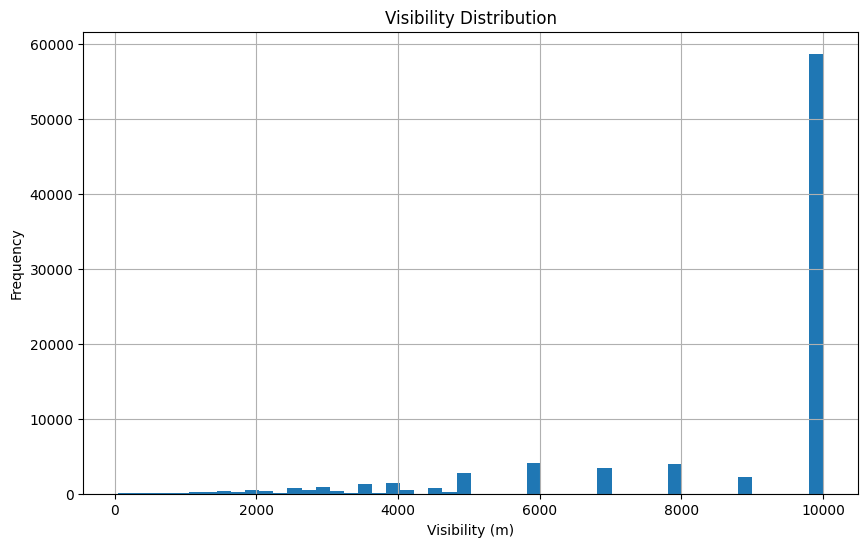

In [ ]:
# VS 변수 분포 확인
plt.figure(figsize=(10, 6))
df['VS'].hist(bins=50)
plt.title('Visibility Distribution')
plt.xlabel('Visibility (m)')
plt.ylabel('Frequency')
plt.show()
# 결과: 시정 데이터가 특정 범위에 편향되어 있음을 나타냄.
# 모델링 시 이러한 분포를 고려하여 데이터 스케일링 또는 이상치 처리 전략을 적용할 필요가 있음.

C:\Users\이성규\AppData\Local\Temp\ipykernel_21744\2829609943.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['VS'], shade=True, color='blue')


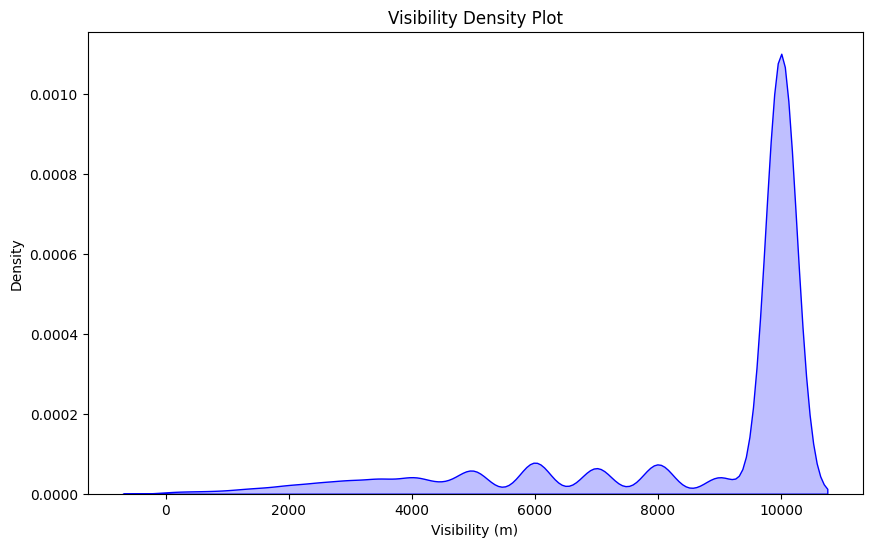

In [ ]:
#히스토그램으로는 데이터의 분포를 명확히 파악하기 어려울 수 있으므로, 커널 밀도 추정(KDE) 플롯을 사용하여 분포를 시각화

plt.figure(figsize=(10, 6))
sns.kdeplot(df['VS'], shade=True, color='blue')
plt.title('Visibility Density Plot')
plt.xlabel('Visibility (m)')
plt.ylabel('Density')
plt.show()

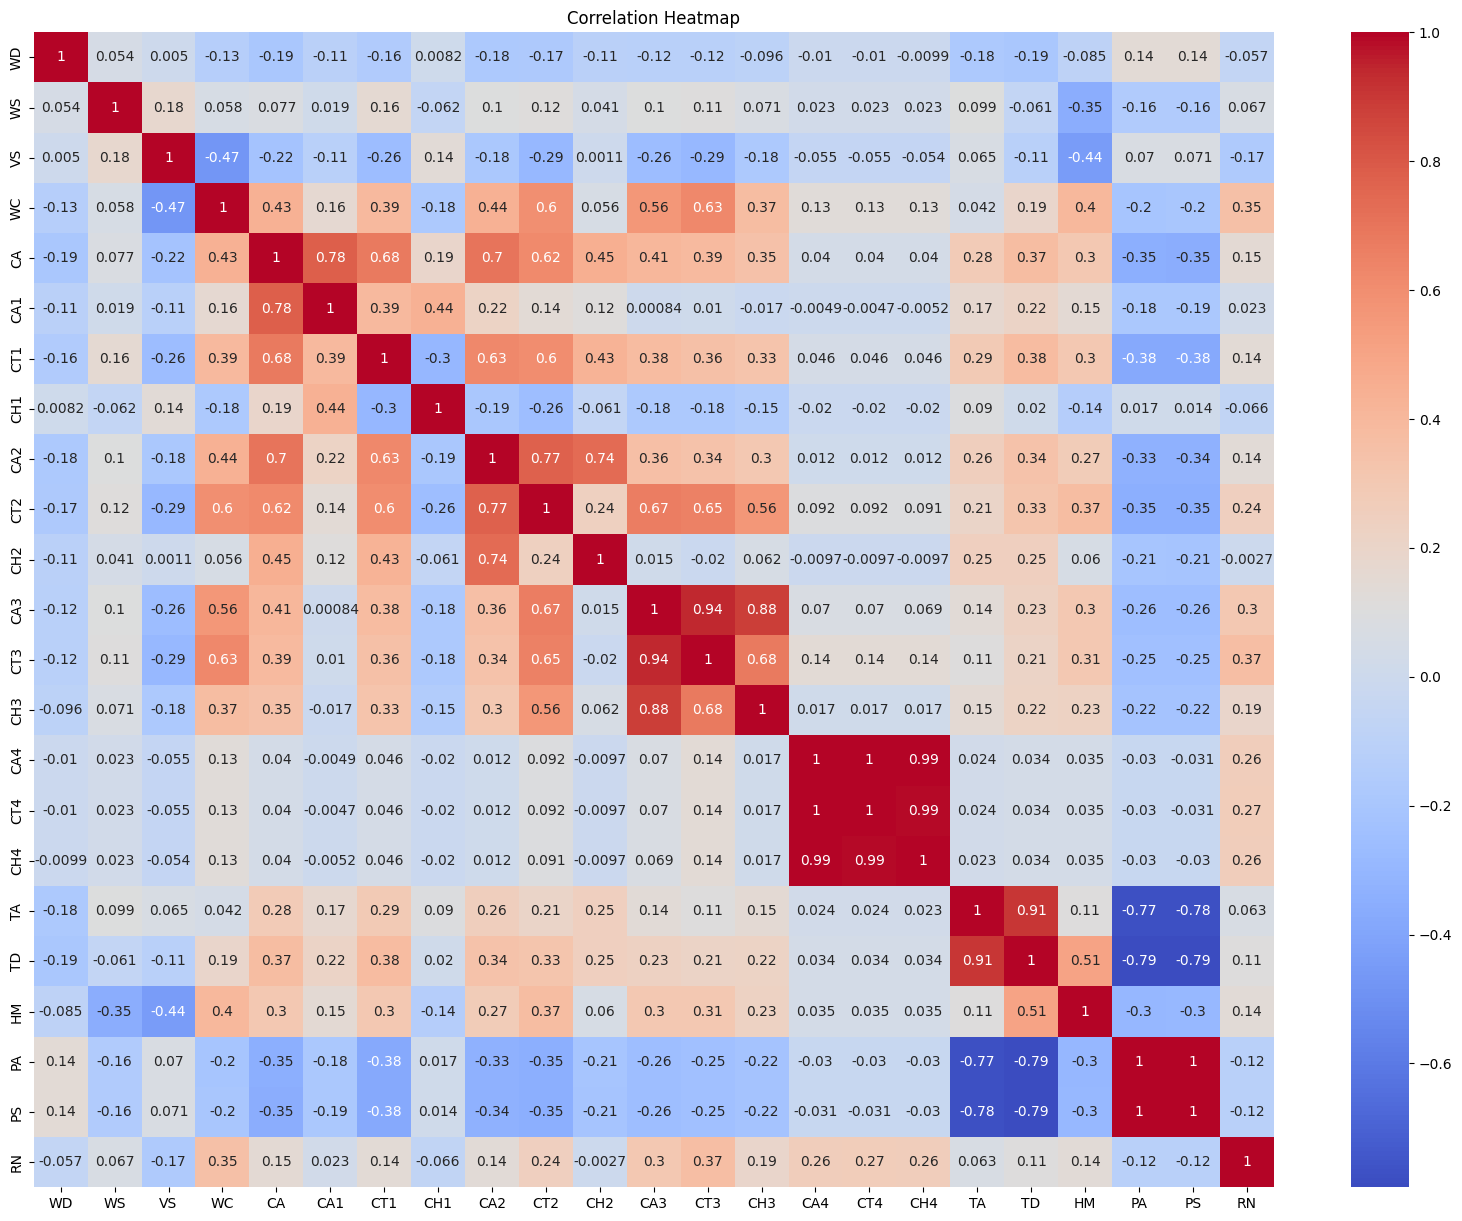

In [12]:
# 변수 간 상관관계 확인
# 피처 간 상관관계를 히트맵으로 시각화
# 관측시각, 국내지점번호는 상관관계 분석에서 제외
corr = df.drop(columns=['TM']).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# VS와 다른 변수들과의 상관관계 계산
vs_corr = corr['VS'].sort_values(ascending=False)

# VS와 다른 변수들의 상관계수 출력
print("Correlation with Visibility (VS):")
print(vs_corr)

"""
PS, PA : 기압과 시정은 대체로 양의 상관관계를 가짐. 기압이 높을수록 대기가 안정되어 시정이 좋아질 가능성이 크다고 예상
-> 실제로는 기압과는 상관계수가 미미하게 존재함, 파생변수로 해면기압과 현지기압의 차이를 구하려고 했는데, 사실상 관측소가 가까워서 그런지 차이가 거의 없음
TA : 기온과 이슬점은 상관관계를 갖기에, 안개 강수등과의 연관은 있을 수 있지만 실제 시정관과계의 직접적인 영향이 크지 않음
WD : 풍향과 시정은 특정 풍향에서 시정이 더 좋거나 나쁠 수 있음 현재는 인천공항의 자료를 사용중이므로, 바다쪽에서 불어오는 바람이 대다수여서 영향이 거의 없음

CH, CA, CT : 구름의 양과 높이는 시정에 영향을 미칠 수 있음. 특히 저층운이 시정에 더 큰 영향을 미칠 수 있음
-> 고층운은 시정에 큰 영향 없음(4층의 경우 drop하는것이 바람직해보임)

WS : 풍속과 시정은 양의 상관관계를 가짐. 바람이 강할수록 대기 중의 입자들이 흩어져 시정이 좋아질 가능성이 큼
TD : 이슬점온도와 시정은 음의 상관관계를 가짐. 이슬점온도가 높을수록 대기 중의 수증기량이 많아져 시정이 나빠질 가능성이 큼
RN : 강수량과 시정은 음의 상관관계를 가짐. 강수량이 많을수록 대기 중의 입자들이 많아져 시정이 나빠질 가능성이 큼
HM : 상대습도와 시정은 음의 상관관계를 가짐. 상대습도가 높을수록 대기 중의 수증기량이 많아져 시정이 나빠질 가능성이 큼
WC : 현재일기 코드와 시정은 특정 일기 상태에서 시정이 더 좋거나 나쁠 수 있음
"""

Correlation with Visibility (VS):
VS     1.000000
WS     0.175695
CH1    0.136567
PS     0.071056
PA     0.070053
TA     0.065460
WD     0.005038
CH2    0.001079
CH4   -0.054424
CA4   -0.054686
CT4   -0.054997
TD    -0.113451
CA1   -0.114317
RN    -0.166707
CH3   -0.176311
CA2   -0.183669
CA    -0.221499
CT1   -0.260703
CA3   -0.264868
CT3   -0.293304
CT2   -0.294023
HM    -0.444943
WC    -0.474471
Name: VS, dtype: float64


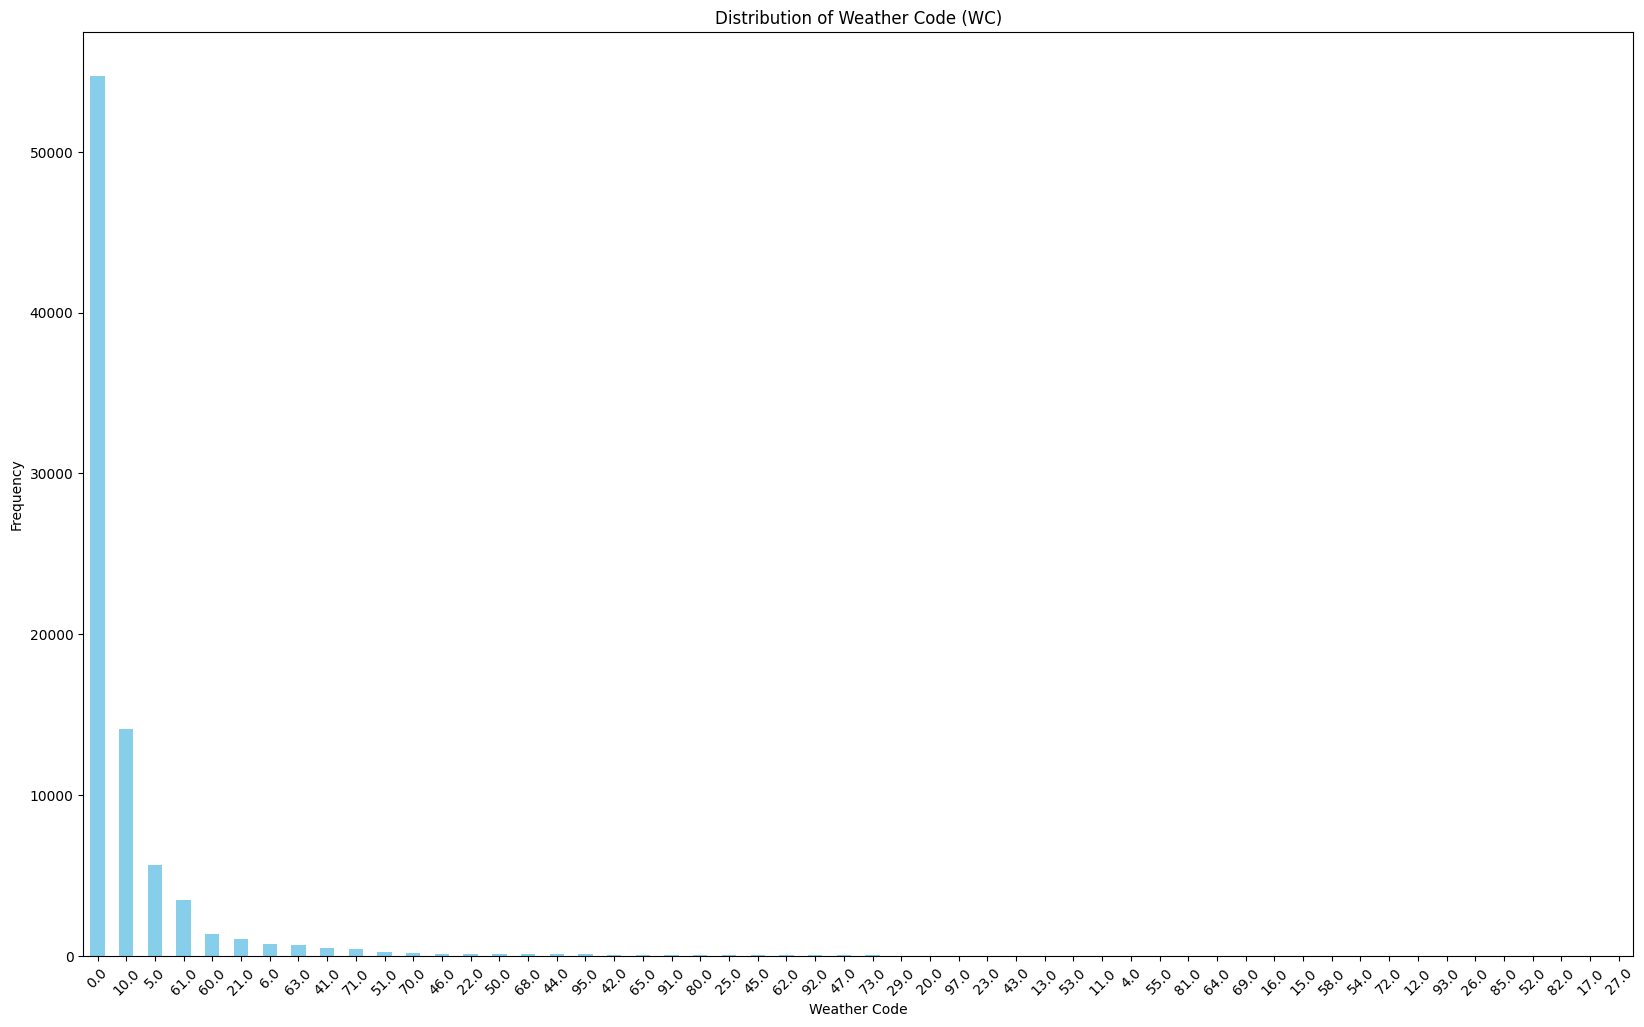

In [19]:
# WC(현재일기 코드) 값 분포
plt.figure(figsize=(20, 12))
df['WC'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Weather Code (WC)')
plt.xlabel('Weather Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 도메인 지식을 토대로 Grouping 기법을 통해서 WC 변수를 범주형 변수로 변환하거나, Encoding 필요해보임
# -> 값의 의미가 없음에도 불구하고, 숫자형 변수로 인식되어 모델에 부정적인 영향을 미칠 수 있음

In [ ]:
df['Pressure_Diff'] = df['PS'] - df['PA']

# Pressure_Diff와 VS 간의 상관계수 계산
correlation = df[['Pressure_Diff', 'VS']].corr().iloc[0, 1]

# 결과 출력
print(f"Correlation between Pressure_Diff and VS: {correlation}")

#상관관계 거의 없음, 파생변수 유의하지 않은것으로 보임.

Correlation between Pressure_Diff and VS: 0.0271764749152765


In [ ]:
df_wc = df.copy()
df_wc["WC"] = pd.to_numeric(df_wc["WC"], errors="coerce")
df_wc["VS"] = pd.to_numeric(df_wc["VS"], errors="coerce")
df_wc = df_wc.dropna(subset=["WC", "VS"]).copy()
df_wc["WC"] = df_wc["WC"].astype(int)

# 1) WMO 4677 기준 대분류 매핑
wc = df_wc["WC"]
conditions = [
    wc.between(0, 3),
    wc.isin([4, 5, 6, 10]),
    wc.between(7, 9) | wc.between(30, 35),
    wc.between(36, 39),
    wc.between(11, 12) | (wc == 28) | wc.between(40, 49),
    wc.between(13, 17),
    wc.between(20, 29),
    (wc == 18),
    (wc == 19),
    wc.between(50, 59),
    wc.between(60, 69),
    wc.between(70, 79),
    wc.between(80, 89),
    wc.between(90, 99),
]
choices = [
    "Sky state change (00–03)",
    "Obscuration: smoke/haze/mist (04–06,10)",
    "Dust/Sand phenomena (07–09,30–35)",
    "Blowing/Drifting snow (36–39)",
    "Fog/Ice fog (11–12,28,40–49)",
    "Distant phenomena (13–17)",
    "Recent weather (20–29)",
    "Squalls (18)",
    "Funnel cloud/Tornado (19)",
    "Drizzle (50–59)",
    "Rain (60–69)",
    "Solid precip (70–79)",
    "Showers (80–89)",
    "Thunderstorm (90–99)",
]
df_wc["WC_GROUP"] = np.select(conditions, choices, default="Other/Unknown")

In [28]:
# 2) 통계 요약 (count, mean, median, 25/75분위)
stats_df = (
    df_wc.groupby("WC_GROUP")["VS"]
    .agg(
        count="count",
        mean="mean",
        median="median",
        q25=lambda s: np.nanpercentile(s, 25),
        q75=lambda s: np.nanpercentile(s, 75),
    )
    .sort_values("median")
    .reset_index()
)
print(stats_df.round(2).to_string(index=False))


                               WC_GROUP  count     mean  median     q25     q75
           Fog/Ice fog (11–12,28,40–49)    951  1548.48  1100.0   500.0  2000.0
                        Drizzle (50–59)    383  3742.17  3200.0  1850.0  5000.0
                   Thunderstorm (90–99)    245  5458.78  5000.0  3000.0  8000.0
Obscuration: smoke/haze/mist (04–06,10)  20517  5908.89  6000.0  4200.0  8000.0
                   Solid precip (70–79)    658  5811.85  6000.0  2500.0 10000.0
                           Rain (60–69)   5787  6675.69  7000.0  4000.0 10000.0
              Distant phenomena (13–17)     29  9724.14 10000.0 10000.0 10000.0
                 Recent weather (20–29)   1349 10000.00 10000.0 10000.0 10000.0
               Sky state change (00–03)  54713 10000.00 10000.0 10000.0 10000.0
                        Showers (80–89)     86  8338.37 10000.0  8000.0 10000.0


In [27]:
# 3) 저시정 비율(1mile, 3mile) 요약
risk_df = (
    df_wc.groupby("WC_GROUP")["VS"]
    .agg(
        n="count",
        Visibility_1000=lambda s: (s.lt(1000).mean() * 100),
        Visibility_1609=lambda s: (s.lt(1609).mean() * 100),
        Visibility_4828=lambda s: (s.lt(4828).mean() * 100),
    )
    .sort_values("Visibility_1000", ascending=False)
    .reset_index()
)
print(risk_df.round(2).to_string(index=False))

                               WC_GROUP     n  Visibility_1000  Visibility_1609  Visibility_4828
           Fog/Ice fog (11–12,28,40–49)   951            47.11            66.25            95.90
                        Drizzle (50–59)   383             7.57            23.76            71.54
                   Solid precip (70–79)   658             5.47            17.63            44.68
                   Thunderstorm (90–99)   245             1.63             7.76            49.80
                           Rain (60–69)  5787             0.22             2.30            31.62
              Distant phenomena (13–17)    29             0.00             0.00             0.00
                 Recent weather (20–29)  1349             0.00             0.00             0.00
Obscuration: smoke/haze/mist (04–06,10) 20517             0.00             1.50            30.00
               Sky state change (00–03) 54713             0.00             0.00             0.00
                        Shower

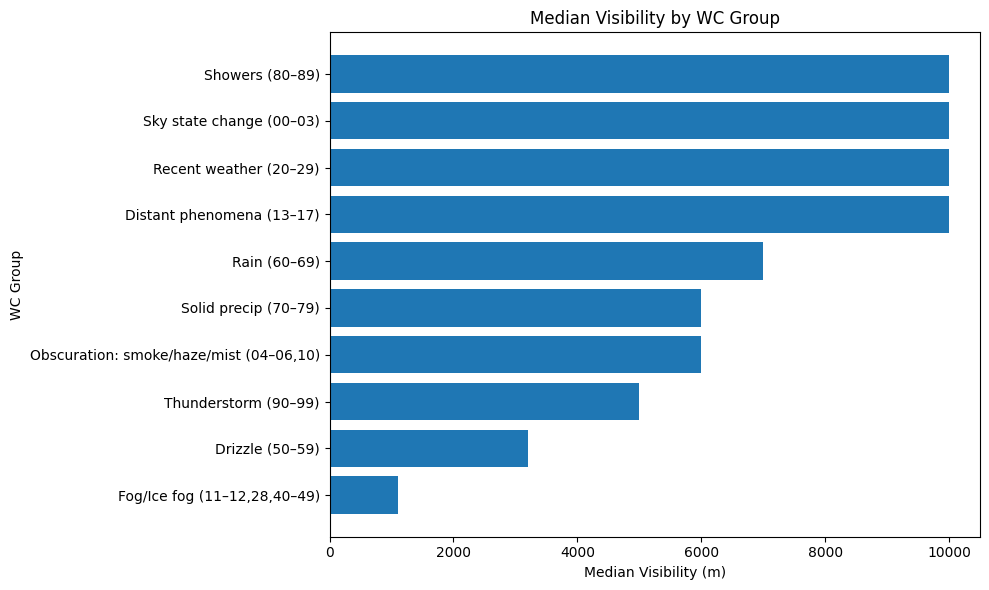

In [ ]:
# 4) 그룹별 시정 중앙값 가로 막대그래프
ordered_groups = stats_df["WC_GROUP"].tolist()
median_by_group = stats_df.set_index("WC_GROUP").loc[ordered_groups, "median"]

plt.figure(figsize=(10, 6))
plt.barh(ordered_groups, median_by_group)
plt.xlabel("Median Visibility (m)")
plt.ylabel("WC Group")
plt.title("Median Visibility")
plt.tight_layout()
plt.show()

C:\Users\이성규\AppData\Local\Temp\ipykernel_21744\26625555.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=ordered_groups, showfliers=False)


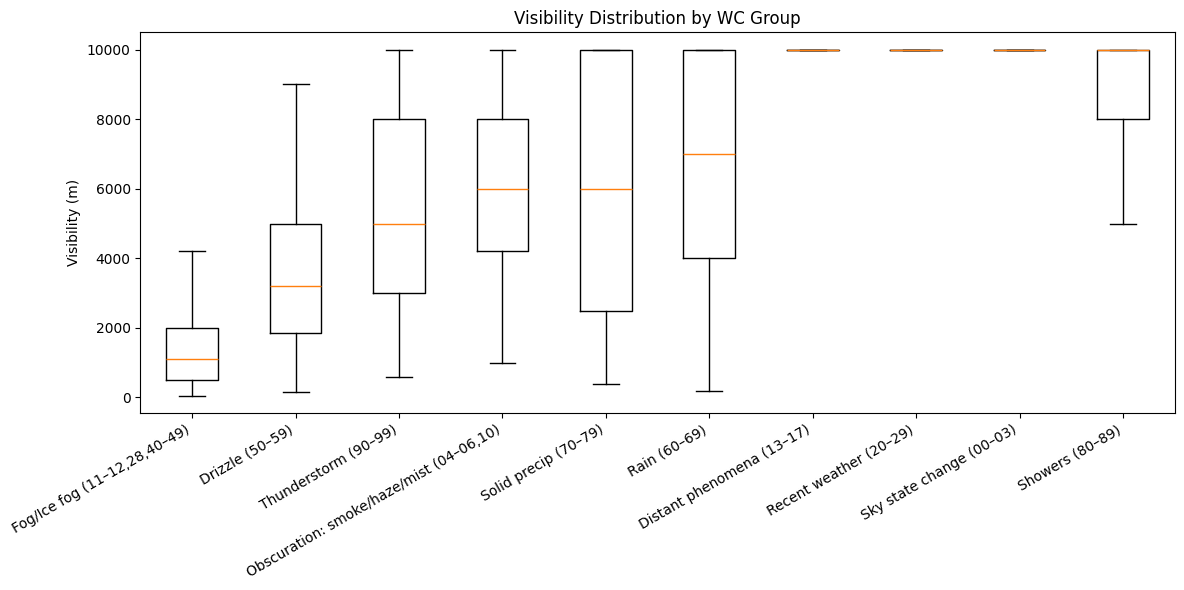

'\nVS와 WC 간의 관계를 분석해보면 아래와 같은 인사이트를 얻을 수 있음:\n1. 안개/빙무(Fog/Ice fog; 11–12, 28, 40–49)\n-> 시정이 매우 낮음 ≈ ~1km, 저시정 비율 VS<1km ≈ 47% / <2km ≈ 69% / <5km ≈ 96%.\n\n2. 이슬비(Drizzle; 50–59)\n저시정 영향 큼. 중앙값 ≈ ~3.3km, <2km ≈ 26% / <5km ≈ 72%.\n\n3. 뇌우(Thunderstorm; 90–99)\n중앙값 중간대(≈ ~5km), 분산 큼. <2km ≈ 9% / <5km ≈ 50%.\n\n4. 고체강수(눈 등; 70–79)\n중간~높은 저하. <2km ≈ 19% / <5km ≈ 45%.\n\n5. 비(Rain; 60–69)\n생각보다 시정 유지되는 케이스 많음. <2km ≈ 3% / <5km ≈ 32%.\n\n6. 소나기(Showers; 80–89), 최근/원거리 현상(20–29, 13–17)\n생각보다 고정적으로 시정이 높은것으로 보임, 그러나 정의상 주변/직전 한 시간 또는 원거리 이벤트라 관측 지점의 즉시 시정 저하는 약함.\n\n7. 나머지\n대부분 시정이 양호함. 특히 먼지/모래(Dust/Sand phenomena; 07–09, 30–35), 바람에 날리는 눈(Blowing/Drifting snow; 36–39)은 시정 영향 거의 없음.\n\n안개/빙무, 이슬비, 눈, 뇌우 + 비 순으로 저시정 위험이 커지는 경향.\n다만 VS는 상한 10km에 값이 치우쳐져 있어 중앙값만으론 차이가 뭉개질 수 있으니, 저시정 비율 지표를 함께 고려하는 것이 바람직.\n\n\n=> WC는 확실히 시정과 밀접한 연관이 있어보임, 상한 시정인 10000m 이상의 데이터가 많아서 상관관계가 다소 낮게 나오는것으로 보임.\n\n=> WC 그룹핑을 통해서 범주형 변수로 변환하는것이 바람직해보임, 대분류로 묶고 one-hot Enocoding을 하는것이 바람직해보임.\n'

In [29]:
# 5) 시각화 — 그룹별 시정 분포 박스플롯(이상치 숨김)
data_for_box = [df_wc.loc[df_wc["WC_GROUP"] == g, "VS"].dropna().values for g in ordered_groups]

plt.figure(figsize=(12, 6))
plt.boxplot(data_for_box, labels=ordered_groups, showfliers=False)
plt.ylabel("Visibility (m)")
plt.title("Visibility Distribution by WC Group")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


"""
VS와 WC 간의 관계를 분석해보면 아래와 같은 인사이트를 얻을 수 있음:
1. 안개/빙무(Fog/Ice fog; 11–12, 28, 40–49)
-> 시정이 매우 낮음 ≈ ~1km, 저시정 비율 VS<1km ≈ 47% / <2km ≈ 69% / <5km ≈ 96%.

2. 이슬비(Drizzle; 50–59)
저시정 영향 큼. 중앙값 ≈ ~3.3km, <2km ≈ 26% / <5km ≈ 72%.

3. 뇌우(Thunderstorm; 90–99)
중앙값 중간대(≈ ~5km), 분산 큼. <2km ≈ 9% / <5km ≈ 50%.

4. 고체강수(눈 등; 70–79)
중간~높은 저하. <2km ≈ 19% / <5km ≈ 45%.

5. 비(Rain; 60–69)
생각보다 시정 유지되는 케이스 많음. <2km ≈ 3% / <5km ≈ 32%.

6. 소나기(Showers; 80–89), 최근/원거리 현상(20–29, 13–17)
생각보다 고정적으로 시정이 높은것으로 보임, 그러나 정의상 주변/직전 한 시간 또는 원거리 이벤트라 관측 지점의 즉시 시정 저하는 약함.

7. 나머지
대부분 시정이 양호함. 특히 먼지/모래(Dust/Sand phenomena; 07–09, 30–35), 바람에 날리는 눈(Blowing/Drifting snow; 36–39)은 시정 영향 거의 없음.

안개/빙무, 이슬비, 눈, 뇌우 + 비 순으로 저시정 위험이 커지는 경향.
다만 VS는 상한 10km에 값이 치우쳐져 있어 중앙값만으론 차이가 뭉개질 수 있으니, 저시정 비율 지표를 함께 고려하는 것이 바람직.


=> WC는 확실히 시정과 밀접한 연관이 있어보임, 상한 시정인 10000m 이상의 데이터가 많아서 상관관계가 다소 낮게 나오는것으로 보임.

=> WC 그룹핑을 통해서 범주형 변수로 변환하는것이 바람직해보임, 대분류로 묶고 one-hot Enocoding을 하는것이 바람직해보임.
"""